In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amzn-polarity-dataset/amazon_polarity/dataset_dict.json
/kaggle/input/amzn-polarity-dataset/amazon_polarity/test/state.json
/kaggle/input/amzn-polarity-dataset/amazon_polarity/test/dataset_info.json
/kaggle/input/amzn-polarity-dataset/amazon_polarity/test/data-00000-of-00001.arrow
/kaggle/input/amzn-polarity-dataset/amazon_polarity/train/state.json
/kaggle/input/amzn-polarity-dataset/amazon_polarity/train/dataset_info.json
/kaggle/input/amzn-polarity-dataset/amazon_polarity/train/data-00000-of-00001.arrow


In [2]:
# Source directory
import shutil

file_name = "amazon_polarity"
source_dir = f"/kaggle/input/amzn-polarity-dataset/{file_name}"

# Destination directory
destination_dir = f"/kaggle/working/{file_name}"

shutil.copytree(source_dir, destination_dir)


'/kaggle/working/amazon_polarity'

In [3]:
import datasets
from transformers import BertTokenizerFast, TFBertForSequenceClassification, BertModel, create_optimizer,TFRobertaForSequenceClassification,  TFBertModel, RobertaTokenizerFast
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2024-06-27 08:36:22.133314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 08:36:22.133448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 08:36:22.301821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
dataset  = datasets.load_from_disk('/kaggle/working/amazon_polarity')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 50000
    })
})

In [6]:
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(20000))
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(80000))

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 20000
    })
})

In [8]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

#### Helper Function for model evaluation

In [9]:
def get_prediction(model, tokenizer, have_token_type_ids=False):
    test_data = dataset['test'].to_tf_dataset(columns=['text'], label_cols=["label"])
    test_sentences = test_data.map(lambda x,y: x)
    labels = test_data.map(lambda x,y: y)
    
    y_true = np.array([label.numpy() for label in labels])
        
    test_sentences = list(test_sentences.as_numpy_iterator())
    test_sentences = [i.decode('utf-8') for i in test_sentences]

    inp = tokenizer(test_sentences, padding="max_length",
                         truncation=True, max_length=200)
    
    input_ids = np.array(inp['input_ids']) 
    attention_mask = np.array(inp['attention_mask'])

    if have_token_type_ids:
        token_type_ids = np.array(inp['token_type_ids'])
        predictions = model.predict({'input_ids': input_ids,
                                     'token_type_ids':token_type_ids, 
                                     'attention_mask': attention_mask})['logits']
        
    else:
        predictions = model.predict({'input_ids': input_ids, 
                                     'attention_mask': attention_mask})['logits']
        
    
    predictions_2 = tf.nn.sigmoid(predictions)
    y_pred = np.argmax(predictions, axis=1)
    
    return y_true, y_pred
        

In [10]:
def get_model_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    preci = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recal = recall_score(y_true, y_pred)
    return {'Accuracy': acc, 'f1_score': f1, 'Precision': preci, 'Recall':recal}


def plot_confusion_matrix(y_true, y_pred, saved_name):
    disp = ConfusionMatrixDisplay.from_predictions(
          y_true, y_pred, 
          labels=[0,1], 
          display_labels=['Negative', 'Positive'], 
          # normalize='true', 
          cmap=plt.cm.Blues
      )

    ax = disp.ax_
    ax.set_title(f'Confusion Matrix for {saved_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual' )

    plt.savefig(f'/kaggle/working/{saved_name}.png')
    plt.show()

# BERT Models

In [12]:
model_id="bert-base-uncased"
bert_tokenizer = BertTokenizerFast.from_pretrained(model_id)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def preprocess_function(examples):
    return bert_tokenizer(examples["text"],padding="max_length",truncation=True, max_length=200)


In [14]:
tokenized_dataset_bert = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [15]:
BATCH_SIZE = 16

train_dataset_bert = tokenized_dataset_bert["train"].to_tf_dataset(
    columns=[  'input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True, 
    batch_size=BATCH_SIZE)

test_dataset_bert = tokenized_dataset_bert["test"].to_tf_dataset(
    columns=[ 'input_ids','token_type_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE)


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [16]:
num_epochs = 1
BATCH_SIZE = BATCH_SIZE
batches_per_epoch = len(tokenized_dataset_bert["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [31]:
bert_model.compile(
    optimizer=optimizer,
    metrics=['accuracy',])

In [32]:
# with tf.device('/device:GPU:0'):

with tf.device('/device:GPU:0'):
    bert_history=bert_model.fit(
        train_dataset_bert,
        validation_data=test_dataset_bert, 
        epochs=1, verbose=1)


5000/5000 [==============================] - 3568s 706ms/step - loss: 0.1423 - accuracy: 0.9473 - val_loss: 0.1280 - val_accuracy: 0.9541


In [33]:
bert_history.history

{'loss': [0.14234347641468048],
 'accuracy': [0.9472500085830688],
 'val_loss': [0.12803755700588226],
 'val_accuracy': [0.9541000127792358]}

In [69]:
get_model_metrics(y_true1, y_pred1)

{'Accuracy': 0.9541,
 'f1_score': 0.95517578125,
 'Precision': 0.9501651447445114,
 'Recall': 0.9602395444728058}

In [56]:
get_model_metrics(y_true, y_pred_3)

{'Accuracy': 0.9541,
 'f1_score': 0.95517578125,
 'Precision': 0.9501651447445114,
 'Recall': 0.9602395444728058}

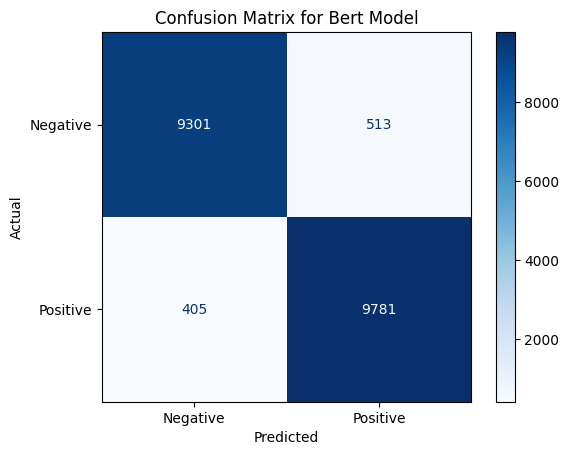

In [57]:
plot_confusion_matrix(y_true, y_pred_3, "Bert Model")

In [70]:
bert_model.save_pretrained('/kaggle/working/bert_model')
bert_tokenizer.save_pretrained('/kaggle/working/bert_tokenizer')

('/kaggle/working/bert_tokenizer/tokenizer_config.json',
 '/kaggle/working/bert_tokenizer/special_tokens_map.json',
 '/kaggle/working/bert_tokenizer/vocab.txt',
 '/kaggle/working/bert_tokenizer/added_tokens.json',
 '/kaggle/working/bert_tokenizer/tokenizer.json')

# Roberta Model


In [11]:
model_id="roberta-base"
roberta_tokenizer=RobertaTokenizerFast.from_pretrained(model_id)
roberta_model=TFRobertaForSequenceClassification.from_pretrained(model_id,num_labels=2)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [12]:
def preprocess_function(examples):
    return roberta_tokenizer(examples["text"],padding='max_length',truncation=True, max_length=200)


In [13]:
tokenized_dataset_roberta = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset_roberta

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
})

In [15]:
BATCH_SIZE = 16

In [16]:
train_dataset_roberta = tokenized_dataset_roberta["train"].to_tf_dataset(
    columns=[  'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True, 
    batch_size=BATCH_SIZE)

test_dataset_roberta = tokenized_dataset_roberta["test"].to_tf_dataset(
    columns=[ 'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE)


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [17]:
num_epochs = 1
batches_per_epoch = len(tokenized_dataset_roberta["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [18]:

roberta_model.compile(#loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [19]:
with tf.device('/device:GPU:0'):
    roberta_history=roberta_model.fit(
        train_dataset_roberta,
        validation_data=test_dataset_roberta,
        epochs=1,callbacks=[early_stop_callback])

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1719477515.988898     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 [==============================] - 3555s 692ms/step - loss: 0.1333 - accuracy: 0.9511 - val_loss: 0.1071 - val_accuracy: 0.9620


In [20]:
roberta_model.save_pretrained('/kaggle/working/roberta_model')

In [21]:
roberta_tokenizer.save_pretrained('/kaggle/working/roberta_tokenizer')

('/kaggle/working/roberta_tokenizer/tokenizer_config.json',
 '/kaggle/working/roberta_tokenizer/special_tokens_map.json',
 '/kaggle/working/roberta_tokenizer/vocab.json',
 '/kaggle/working/roberta_tokenizer/merges.txt',
 '/kaggle/working/roberta_tokenizer/added_tokens.json',
 '/kaggle/working/roberta_tokenizer/tokenizer.json')

In [22]:
shutil.make_archive('/kaggle/working/roberta_tokenizer', 'zip', '/kaggle/working/roberta_tokenizer')


'/kaggle/working/roberta_tokenizer.zip'

In [23]:
shutil.make_archive('/kaggle/working/roberta_model', 'zip', '/kaggle/working/roberta_model')


'/kaggle/working/roberta_model.zip'

### Save the Model to onnx format

In [32]:
# !pip install onnxruntime
# !pip install tf2onnx

import onnxruntime as rt
import onnx
import tf2onnx

In [33]:
model_path = '/kaggle/working/roberta_model'
loaded_model = TFRobertaForSequenceClassification.from_pretrained(model_path)

spec = (tf.TensorSpec((None, 200), tf.int32, name="input_ids"),
        tf.TensorSpec((None, 200), tf.int32, name="attention_mask"))


output_path = "/kaggle/working/roberta_model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(loaded_model, input_signature=spec, opset=13, output_path=output_path)

print(f"Model has been converted to ONNX and saved at {output_path}")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /kaggle/working/roberta_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model has been converted to ONNX and saved at /kaggle/working/roberta_model.onnx


In [34]:
output_names = [out.name for out in model_proto.graph.output]
output_names



['logits']

In [35]:
model_onnx_path = output_path
quant_model_path = "/kaggle/working/roberta_model_quant.onnx"

In [36]:
from onnxruntime.quantization import quantize_dynamic, QuantType

In [37]:
quantized_model = quantize_dynamic(model_onnx_path, quant_model_path,
                                   weight_type=QuantType.QUInt8)

### Roberta Evaluation

In [25]:
roberta_history.history

{'loss': [0.14118024706840515, 0.0857912227511406, 0.05013497546315193],
 'accuracy': [0.9482374787330627, 0.9708874821662903, 0.9843500256538391],
 'val_loss': [0.11715178191661835, 0.111954465508461, 0.1379684954881668],
 'val_accuracy': [0.9574000239372253, 0.9612500071525574, 0.9610999822616577]}

In [25]:
y_true_ro, y_pred_ro = get_prediction(roberta_model, roberta_tokenizer, have_token_type_ids=False)


625/625 [==============================] - 285s 442ms/step


In [26]:
roberta_metrics = get_model_metrics(y_true_ro, y_pred_ro)
roberta_metrics

{'Accuracy': 0.9576,
 'f1_score': 0.9587468379062074,
 'Precision': 0.9502410800385728,
 'Recall': 0.9674062438641272}

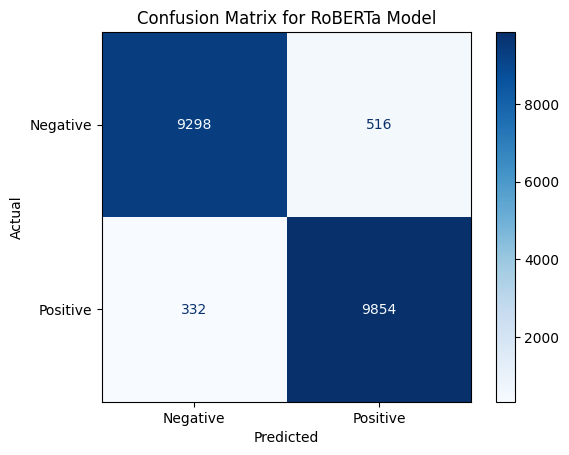

In [27]:
plot_confusion_matrix(y_true_ro, y_pred_ro, "RoBERTa Model")

# DistilBERT

In [30]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast

import tensorflow as tf

distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [31]:
def tokenize_fn(examples):
    return distilbert_tokenizer(examples["text"],padding='max_length',truncation=True, max_length=200)


In [32]:
tokenized_dataset_distilbert = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [33]:
train_dataset_distilbert = tokenized_dataset_distilbert["train"].to_tf_dataset(
    columns=[  'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True, 
    batch_size=BATCH_SIZE)

test_dataset_distilbert = tokenized_dataset_distilbert["test"].to_tf_dataset(
    columns=[ 'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE)


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [35]:
num_epochs = 4
batches_per_epoch = len(tokenized_dataset_distilbert["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)



In [36]:

distilbert_model.compile(#loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [ ]:
with tf.device('/device:GPU:0'):
    distilbert_history=distilbert_model.fit(
        train_dataset_distilbert,
        validation_data=test_dataset_distilbert, 
        epochs=4, verbose=1, callbacks=[early_stop_callback])


Epoch 1/4
5000/5000 [==============================] - 1886s 371ms/step - loss: 0.1711 - accuracy: 0.9346 - val_loss: 0.1460 - val_accuracy: 0.9487
Epoch 2/4
4816/5000 [===========================>..] - ETA: 1:02 - loss: 0.0915 - accuracy: 0.9682

In [39]:
distilbert_history.history

{'loss': [0.1711411476135254, 0.0913352370262146],
 'accuracy': [0.934612512588501, 0.9681500196456909],
 'val_loss': [0.14603763818740845, 0.14746202528476715],
 'val_accuracy': [0.9486500024795532, 0.9483500123023987]}

In [40]:
y_true_dis, y_pred_dis = get_prediction(distilbert_model, distilbert_tokenizer, have_token_type_ids=False)


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


625/625 [==============================] - 150s 235ms/step


In [41]:
distilbert_metrics = get_model_metrics(y_true_dis, y_pred_dis)


In [42]:
distilbert_metrics

{'Accuracy': 0.94865,
 'f1_score': 0.949326491340603,
 'Precision': 0.9542704096815792,
 'Recall': 0.9444335362261929}

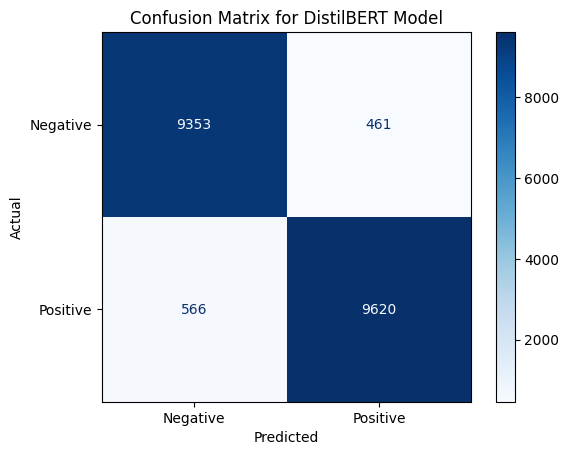

In [43]:
plot_confusion_matrix(y_true_dis, y_pred_dis, "DistilBERT Model")

In [44]:
bert_metrics = {'Accuracy': 0.9541,
 'f1_score': 0.95517578125,
 'Precision': 0.9501651447445114,
 'Recall': 0.9602395444728058}


## Models Comparison

In [46]:
metrics = {
    'BERT': bert_metrics,
    'RoBERTa':roberta_metrics,
    'DistilBERT': distilbert_metrics,
}

In [48]:
metrics_df = pd.DataFrame(metrics)

In [49]:
metrics_df

,BERT,RoBERTa,DistilBERT
Accuracy,0.954100,0.957600,0.948650
f1_score,0.955176,0.958747,0.949326
Precision,0.950165,0.950241,0.954270
Recall,0.960240,0.967406,0.944434


In [51]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen; color: dark' if v else '' for v in is_max]


styled_df = metrics_df.style.apply(highlight_max, subset=['BERT', 'RoBERTa', 'DistilBERT'], axis=1)

styled_df


,BERT,RoBERTa,DistilBERT
Accuracy,0.954100,0.957600,0.948650
f1_score,0.955176,0.958747,0.949326
Precision,0.950165,0.950241,0.954270
Recall,0.960240,0.967406,0.944434


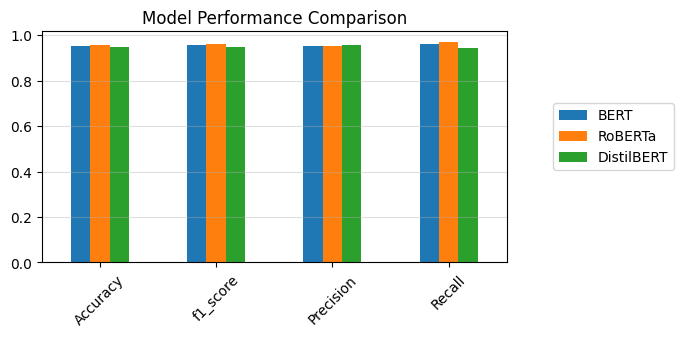

In [55]:
ax = metrics_df.plot.bar(rot=45, figsize=(6, 3))
plt.legend(loc=[1.1, .4])
plt.grid(axis='y', alpha=.4)

plt.title('Model Performance Comparison')
plt.savefig('metrics_comparison.png', bbox_inches='tight')


In [56]:
from sklearn.metrics import classification_report

In [61]:
print("        classification report for DistilBERT \n")
print(classification_report(y_true_dis, y_pred_dis))


        classification report for DistilBERT 

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      9814
           1       0.95      0.94      0.95     10186

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



In [62]:
print("        classification report for RoBERTa \n")
print(classification_report(y_true_ro, y_pred_ro))


        classification report for RoBERTa 

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      9814
           1       0.95      0.97      0.96     10186

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

